[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/Regularization.ipynb)


# Regularization

We saw that linear least squares can be seen as maximizing the likelihood $L(w) = \prod_{(x,y) \in \mathcal{D}} p(y|x, w)$, where $p(y|x;w)$ is a Gaussian with the mean $w^\top x$ and fixed variance. In logistic regression $p(y|x, w)$ is a Bernoulli distribution with mean $\sigma(w^\top x)$.
In both cases we find the maximum likelihood solution. Instead of maximizing the likelihood, we can find the maximum of the posterior over model parameters. That is we have the prior $p(w)$, as well as the likelihood $p(y| X, w) = \prod_{x,y \in \mathcal{D}} p(y|x, w)$. Using Bayes rule the posterior is *proportional* to the product of these two terms $p(w| X,y) \propto p(w) p(y|X, w)$. Maximizing the logarithm of the posterior becomes

$$
\arg\max_w \log L(w) + \log p(w) = \arg\min_w  J(w) - \log p(w)
$$

where the cost function $J(w)$ (e.g., L2 or cross-entropy cost) is the negative of the log-likelihood.
We see that different choices of prior $p(w)$ simply add different types of penalty to our original cost function.
Choosing an isotropic Gaussian prior $p(w) = \prod_d \mathcal{N}(w_d|0, \frac{1}{\lambda})$ gives us L2 regularization:

$$
\log p(w) = \sum_d \log \mathcal{N}(w_d|0, \frac{1}{\lambda}) = - \frac{\lambda}{2} \sum_d w_d^2 + \mathrm{constant}
$$

where the constant terms are additive terms that do not depend on $w$. 
Similarly, using **Laplace prior** $p(w) = \frac{1}{2 \beta} \prod_d \exp \left (\frac{|w|}{\beta} \right)$ gives L1 regularization:

$$
\log p(w) = - {\lambda} \sum_d |w_d| + \mathrm{constant}
$$

where we set $\lambda = \frac{1}{\beta}$.

Below let's see the effect of this penalty term on the landscape of the regularized cost function in working with toy data. 

In [57]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import itertools

In [58]:
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

Let's create a toy data:

In [59]:
N = 20
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)

visualize the regularized **cost function** 

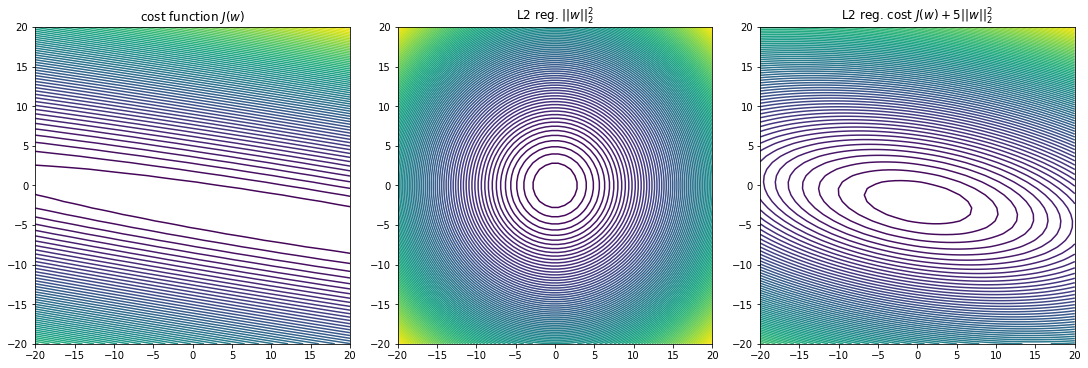

In [64]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
l2_penalty = lambda w: np.dot(w,w)/2
l1_penalty = lambda w: np.sum(np.abs(w))
cost_plus_l2 = lambda w: cost(w) + 5*l2_penalty(w)

fig, axes = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15, 5))
plot_contour(cost, [-20,20], [-20,20], 50, axes[0])
axes[0].set_title(r'cost function $J(w)$')
plot_contour(l2_penalty, [-20,20], [-20,20], 50, axes[1])
axes[1].set_title(r'L2 reg. $||w||_2^2$')
plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[2])
axes[2].set_title(r'L2 reg. cost $J(w) + 5 ||w||_2^2$')
plt.show()

Let's use the `GradientDescent` and `LinearRegression` classes from the previous lecture. The only update we have made is in using `l2_reg` which sets the regularization coefficient $\lambda$ for L2 regularization. This information is used when calculating the gradient to perform weight decay. Note that a good practice is to *avoid penalizing the bias* $w_0$. Here, for the sake of visualization we penalize the bias as well.

In [61]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w
    
class LinearRegression:
    def __init__(self, add_bias=True, l2_reg=0):
        self.add_bias = add_bias
        self.l2_reg = l2_reg
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad += self.l2_reg* w
            return grad
        w0 = np.zeros(D)
        self.w = optimizer.run(gradient, x, y, w0)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Now let's visualize the landscape of regularized cost function for different amounts of regularization and see the effect of regularization on gradient descent.

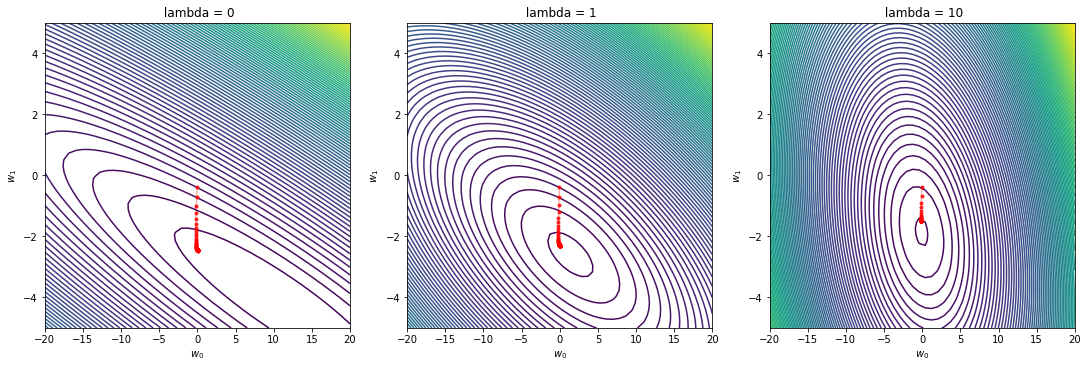

In [62]:
cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
reg_list = [0, 1, 10]
fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(15, 5))
for i, reg_coef in enumerate(reg_list):
    optimizer = GradientDescent(learning_rate=.01, max_iters=50, record_history=True)
    model = LinearRegression(optimizer, l2_reg=reg_coef)
    model.fit(x,y, optimizer)
    current_cost = lambda w: cost(w, reg_coef)
    plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)# T x 2
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f' lambda = {reg_coef}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()

The plots show that L2 regularization helps with the convergence of gradient descent.